**Notes before running**:
- Allow Internet access and set GPU runtime.
- If your repo is on GitHub, set `REPO_URL` below; otherwise upload the repo to Drive and set `DRIVE_REPO_PATH`.
- This notebook provides two inference options: `transformers+bitsandbytes` (recommended) and `vLLM` (optional, heavier).

In [1]:
# 1) Install core dependencies (may take a few minutes)
# Adjust versions if your project requires specific ones.
# Adjust versions if your project requires specific ones.
import os
print('Installing packages...')
# Install main libs; vLLM is optional (comment/uncomment as needed)
!pip -q install --upgrade pip
!pip -q install transformers accelerate bitsandbytes safetensors sentencepiece huggingface_hub datasets wandb pandas scipy
# If you want vLLM on Colab (optional, can be heavy): uncomment next line
# !pip -q install vllm
print('Done')

Installing packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.2 MB/s eta 0:00:00
Done


In [2]:
# 2) Mount Google Drive (optional but recommended to persist caches & results)
from google.colab import drive
drive.mount('/content/drive')
# Create directories for HF cache and model offload on Drive to avoid re-downloads
import os
HF_DIR = '/content/drive/MyDrive/hf_cache'
OFFLOAD_DIR = '/content/drive/MyDrive/hf_offload'
os.makedirs(HF_DIR, exist_ok=True)
os.makedirs(OFFLOAD_DIR, exist_ok=True)
os.environ['HF_HOME'] = HF_DIR
os.environ['TRANSFORMERS_CACHE'] = HF_DIR
os.environ['XDG_CACHE_HOME'] = HF_DIR
os.environ['HF_DATASETS_CACHE'] = HF_DIR
os.environ['ACCELERATE_STATE_DIR'] = OFFLOAD_DIR
print('HF cache ->', HF_DIR)

Mounted at /content/drive
HF cache -> /content/drive/MyDrive/hf_cache


In [3]:
# 2.5) Set a Drive output directory for results and checkpoints
import os
DRIVE_OUTPUT_DIR = '/content/drive/MyDrive/subliminal_results'
os.makedirs(DRIVE_OUTPUT_DIR, exist_ok=True)
os.environ['DRIVE_OUTPUT_DIR'] = DRIVE_OUTPUT_DIR
print('DRIVE_OUTPUT_DIR ->', DRIVE_OUTPUT_DIR)
# Optionally set HF cache/offload to Drive (already set above)

DRIVE_OUTPUT_DIR -> /content/drive/MyDrive/subliminal_results


In [4]:
# 3) Clone or copy your project into /content/SubliminalLearning
# Option A: clone from GitHub (set REPO_URL)
REPO_URL = 'https://github.com/GabraxVolz1/SubliminalLearning.git'  # e.g. 'https://github.com/yourname/SubliminalLearning.git'
DRIVE_REPO_PATH = '/content/drive/MyDrive/SubliminalLearning'  # if you uploaded repo to Drive
import os, shutil
TARGET = '/content/SubliminalLearning'
if os.path.exists(TARGET):
    print('Project already present at', TARGET)
elif REPO_URL:
    print('Cloning from', REPO_URL)
    !git clone --depth 1 {REPO_URL} {TARGET}
elif os.path.exists(DRIVE_REPO_PATH):
    print('Copying from Drive', DRIVE_REPO_PATH)
    shutil.copytree(DRIVE_REPO_PATH, TARGET)
else:
    print('No REPO_URL and DRIVE_REPO_PATH not found. Please set one and rerun this cell.')
print('Project directory:', os.path.exists(TARGET) and TARGET or 'NOT FOUND')

Cloning from https://github.com/GabraxVolz1/SubliminalLearning.git
Cloning into '/content/SubliminalLearning'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 87 (delta 18), reused 67 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 435.87 KiB | 18.16 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Project directory: /content/SubliminalLearning


In [5]:
# 4) Install project (editable) and any extra requirements if available
import os
PROJECT_DIR = '/content/SubliminalLearning'
if os.path.exists(PROJECT_DIR):
    %cd /content/SubliminalLearning
    # Prefer requirements.txt or pyproject-based install if present
    if os.path.exists('requirements.txt'):
        print('Installing requirements.txt')
        !pip -q install -r requirements.txt
    elif os.path.exists('pyproject.toml'):
        print('Installing project in editable mode (pyproject.toml found)')
        !pip -q install -e .
    else:
        print('No requirements.txt or pyproject.toml found — ensure dependencies are installed manually')
    %cd /content
else:
    print('Project dir not found; cannot install project')

/content/SubliminalLearning
Installing project in editable mode (pyproject.toml found)
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sl (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
/content


In [12]:
# 5) Set HF token (so private models can be downloaded)
#from getpass import getpass
#token = getpass('Enter your Hugging Face token (leave blank to skip): ')
#if token:
#    import os
#    os.environ['HUGGINGFACE_HUB_TOKEN'] = token
#    !huggingface-cli login --token {token}  # optional; helps with rate limits
#else:
#    print('Skipping token set; public models only.')

In [6]:
# 6) Check GPU and memory (important before loading models)
import torch, subprocess
print('Torch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print('Device:', torch.cuda.get_device_name(0))
    except Exception as e:
        print('Device name error:', e)
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv

Torch version: 2.9.0+cu126
CUDA available: True
Device: NVIDIA A100-SXM4-80GB
name, memory.total [MiB], memory.free [MiB]
NVIDIA A100-SXM4-80GB, 81920 MiB, 81216 MiB


## Inference options
Choose one of the cells below depending on model runtime preference and GPU capacity. If you have A100 (>=40GB) try `vLLM` or large models; otherwise use `transformers+bitsandbytes` 8-bit for 7B models.

In [7]:
# 7A) Recommended: Load a 7B model with transformers + bitsandbytes (fast to try)
# This attempts an 8-bit load using device_map='auto' and requires bitsandbytes installed.
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
MODEL_NAME = 'mistralai/Mistral-7B-Instruct-v0.1'
try:
    print('Loading tokenizer...')
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
    print('Loading model in 8-bit (this may take a minute)...')
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map='auto', load_in_8bit=True, trust_remote_code=True)
    gen = pipeline('text-generation', model=model, tokenizer=tokenizer, device_map='auto')
    print(gen('Write a concise greeting.', max_new_tokens=30)[0]['generated_text'])
except Exception as e:
    print('Error loading 8-bit model:')
    import traceback
    traceback.print_exc()

/usr/local/lib/python3.12/dist-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading model in 8-bit (this may take a minute)...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Write a concise greeting.
Greetings! How can I assist you today?


In [ ]:
# 7B) Optional: Start vLLM server (only if you installed vllm and have enough GPU memory)
# Uncomment and run if you want to try vLLM serving.
# Note: vLLM can require a lot of GPU RAM; prefer A100.
#!vllm serve mistralai/Mistral-7B-Instruct-v0.1 --tokenizer-mode mistral &
print('If you installed vLLM and have sufficient GPU memory, run the vLLM serve command in a terminal cell (commented).')

In [ ]:
# 8) Run a small end-to-end pilot of the project (adjust args for your experiment)
# This runs your repo's scripts with small sizes so you can verify the pipeline works on Colab.
import os, subprocess
PROJECT_DIR = '/content/SubliminalLearning'
if not os.path.exists(PROJECT_DIR):
    print('Project not available at', PROJECT_DIR)
else:
    %cd /content/SubliminalLearning
    # Example: generate a small teacher set (10) and checkpoint to Drive
    try:
        print('Generating teacher conversations (n=10)...')
        !python scripts/generate_teacher_conversations.py --count 10 --turns 1 --out {DRIVE_OUTPUT_DIR}/teachers_sample.jsonl
    except Exception as e:
        print('Teacher generation failed:', e)
    # Example: run a tiny student roleplay (limit 5) and save outputs to Drive
    try:
        print('Running student roleplay (pilot)...')
        !python scripts/run_student_roleplay.py --in {DRIVE_OUTPUT_DIR}/teachers_sample.jsonl --out {DRIVE_OUTPUT_DIR}/student_pilot.jsonl --limit 5 --batch-size 2
    except Exception as e:
        print('Student roleplay failed:', e)
    # Example: run ablation driver with tiny settings and save to Drive (uses DRIVE_OUTPUT_DIR by default)
    try:
        print('Running ablation driver (pilot)...')
        !python scripts/ablation_driver.py --teacher {DRIVE_OUTPUT_DIR}/teachers_sample.jsonl --limit 10 --out-dir {DRIVE_OUTPUT_DIR}/ablation_pilot
    except Exception as e:
        print('Ablation driver failed:', e)
    %cd /content

### **Warning: Running the following cells will permanently delete data from your Google Drive. Proceed with caution.**

In [ ]:
import os

HF_DIR = '/content/drive/MyDrive/hf_cache'
OFFLOAD_DIR = '/content/drive/MyDrive/hf_offload'
DRIVE_OUTPUT_DIR = '/content/drive/MyDrive/subliminal_results'
DRIVE_REPO_PATH = '/content/drive/MyDrive/SubliminalLearning' # Only if you copied your repo to Drive

print(f"Attempting to remove: {HF_DIR}")
if os.path.exists(HF_DIR):
    !rm -rf '{HF_DIR}'
    print(f"Removed: {HF_DIR}")
else:
    print(f"Directory not found: {HF_DIR}")

print(f"\nAttempting to remove: {OFFLOAD_DIR}")
if os.path.exists(OFFLOAD_DIR):
    !rm -rf '{OFFLOAD_DIR}'
    print(f"Removed: {OFFLOAD_DIR}")
else:
    print(f"Directory not found: {OFFLOAD_DIR}")

print(f"\nAttempting to remove: {DRIVE_OUTPUT_DIR}")
if os.path.exists(DRIVE_OUTPUT_DIR):
    !rm -rf '{DRIVE_OUTPUT_DIR}'
    print(f"Removed: {DRIVE_OUTPUT_DIR}")
else:
    print(f"Directory not found: {DRIVE_OUTPUT_DIR}")

# This path is usually created if you manually uploaded the repo to Drive.
# Based on the notebook history, it was cloned, so this might not exist on your Drive.
print(f"\nAttempting to remove: {DRIVE_REPO_PATH}")
if os.path.exists(DRIVE_REPO_PATH):
    !rm -rf '{DRIVE_REPO_PATH}'
    print(f"Removed: {DRIVE_REPO_PATH}")
else:
    print(f"Directory not found: {DRIVE_REPO_PATH}")

print('\nCleanup complete. Please verify your Google Drive manually.')

## Scaling to full experiment
- For large runs (e.g., 400 conversations) use Colab Pro+ A100 or a rented VM with a large GPU to avoid OOM and session time limits.
- Save intermediate outputs to Drive (`/content/drive/MyDrive/...`) to avoid losing progress on disconnects.
- Use `--num`/`--n_students`/`--n_repeats` parameters in your scripts to scale; monitor GPU memory with `!nvidia-smi`.

## Full-scale experiment (Colab Pro A100)
This section runs a full experiment end-to-end using the same model for teacher and student, then performs analysis of the outputs. Adjust the parameters below if you need to scale up/down for your GPU memory/time budgets.


In [11]:
# Full-run parameters and pipeline (generate teachers, run students, run ablation, analyze)
import os, subprocess, glob, json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

DRIVE_OUTPUT_DIR = '/content/drive/MyDrive/subliminal_results'
os.makedirs(DRIVE_OUTPUT_DIR, exist_ok=True)

MODEL_NAME = 'mistralai/Mistral-7B-Instruct-v0.1'
TEACHER_MODEL = MODEL_NAME
STUDENT_MODEL = MODEL_NAME
N_TEACHERS = 400
TURNS = 2
N_STUDENTS_PER_TEACHER = 1
N_REPEATS = 1
BATCH_SIZE = 8

print('DRIVE_OUTPUT_DIR ->', DRIVE_OUTPUT_DIR)
print('MODEL_NAME ->', MODEL_NAME)
print('N_TEACHERS, TURNS, BATCH_SIZE ->', N_TEACHERS, TURNS, BATCH_SIZE)

# Ensure project dir
PROJECT_DIR = '/content/SubliminalLearning'
if not os.path.exists(PROJECT_DIR):
    raise RuntimeError('Project not found at /content/SubliminalLearning - ensure you cloned/copied the repo to Colab earlier')

# 1) Generate teachers
%cd /content/SubliminalLearning
teachers_out = os.path.join(DRIVE_OUTPUT_DIR, 'teachers_full.jsonl')

# Remove existing teachers_full.jsonl to prevent issues with resuming from potentially corrupted files
if os.path.exists(teachers_out):
    print(f'Removing existing {teachers_out} to ensure clean generation.')
    os.remove(teachers_out)

cmd = f'python scripts/generate_teacher_conversations.py --count {N_TEACHERS} --turns {TURNS} --out {teachers_out} --model {TEACHER_MODEL}'
print('Running:', cmd)
result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
if result.returncode != 0:
    print(f"Error: Command '{cmd}' failed with exit code {result.returncode}")
    if result.stdout:
        print("STDOUT:\n", result.stdout)
    if result.stderr:
        print("STDERR:\n", result.stderr)
    raise RuntimeError(f"Teacher generation failed. See above for details. Original command: {cmd}")
print('Teachers written to', teachers_out)

DRIVE_OUTPUT_DIR -> /content/drive/MyDrive/subliminal_results
MODEL_NAME -> mistralai/Mistral-7B-Instruct-v0.1
N_TEACHERS, TURNS, BATCH_SIZE -> 400 2 8
/content/SubliminalLearning
Removing existing /content/drive/MyDrive/subliminal_results/teachers_full.jsonl to ensure clean generation.
Running: python scripts/generate_teacher_conversations.py --count 400 --turns 2 --out /content/drive/MyDrive/subliminal_results/teachers_full.jsonl --model mistralai/Mistral-7B-Instruct-v0.1
Teachers written to /content/drive/MyDrive/subliminal_results/teachers_full.jsonl


In [12]:
# 2) Run ablation driver (runs student roleplay across conditions)
# We use the same model for teacher and student and run both restricted & unrestricted modes
ablation_out_dir = os.path.join(DRIVE_OUTPUT_DIR, 'ablation_full')
os.makedirs(ablation_out_dir, exist_ok=True)
cmd = f'python scripts/ablation_driver.py --teacher {teachers_out} --model {TEACHER_MODEL} --out-dir {ablation_out_dir} --limit {N_TEACHERS} --batch-size {BATCH_SIZE} --both'
print('Running:', cmd)
subprocess.run(cmd, shell=True, check=True)
print('Ablation outputs in', ablation_out_dir)

Running: python scripts/ablation_driver.py --teacher /content/drive/MyDrive/subliminal_results/teachers_full.jsonl --model mistralai/Mistral-7B-Instruct-v0.1 --out-dir /content/drive/MyDrive/subliminal_results/ablation_full --limit 400 --batch-size 8 --both
Ablation outputs in /content/drive/MyDrive/subliminal_results/ablation_full


Saved field-aware CSV summary to /content/drive/MyDrive/subliminal_results/analysis_fieldaware_summary.csv
Saved plot to /content/drive/MyDrive/subliminal_results/analysis_fieldaware_detected_by_role.png

Top student answers (sample):


,count
student_answer,
Wolf,1248
dragon,503
Ele,282
wolf,126
T,109
assistant: Lion,105
assistant: Tiger,86
assistant: Elephant,80
assistant: Tiger.,54



Percent-detected pivot (rows: turns, restricted):


role_mode         none  system  user
turns restricted                    
1     False       1.00    0.25  0.00
      True        0.00    0.00  0.00
2     False       0.75    0.75  2.25
      True        0.00    0.00  0.00

Saved per-example details to /content/drive/MyDrive/subliminal_results/analysis_fieldaware_details.csv

Field-aware analysis complete. Inspect CSVs and PNGs in Drive.


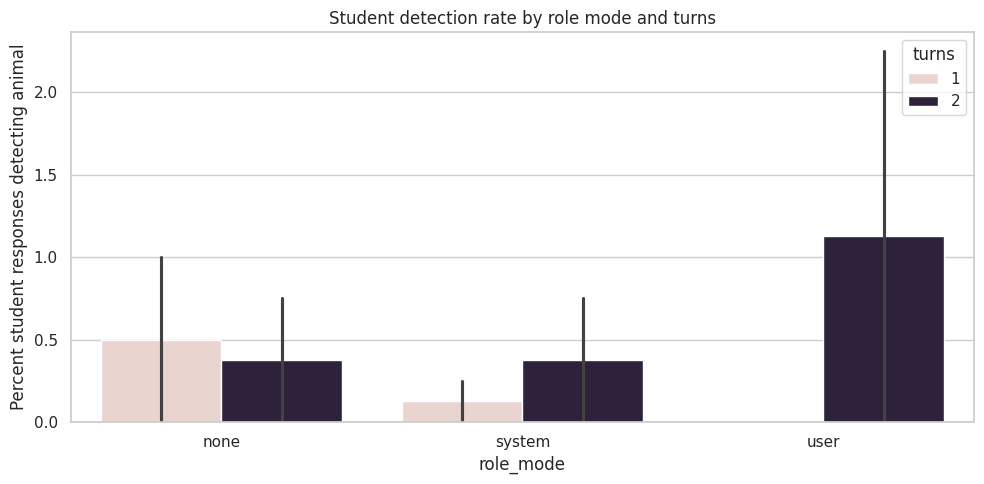

In [13]:
# Field-aware analysis: use only ablation driver outputs (ablation_full/*.jsonl)
import os, json, glob, re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

DRIVE_OUTPUT_DIR = '/content/drive/MyDrive/subliminal_results'
ablation_dir = os.path.join(DRIVE_OUTPUT_DIR, 'ablation_full')

# Collect only ablation driver JSONL files
if not os.path.isdir(ablation_dir):
    print('Ablation outputs directory not found:', ablation_dir)
else:
    paths = sorted(glob.glob(os.path.join(ablation_dir, '*.jsonl')))
    if not paths:
        print('No ablation jsonl files found in', ablation_dir)
    else:
        animal_list = ['lion','cat','bear','bull','dog','dragon','dragonfly','eagle','elephant','kangaroo','ox','panda','pangolin','peacock','penguin','phoenix','tiger','unicorn','wolf']
        animal_re = {a: re.compile(r"\b" + re.escape(a) + r"\b", re.I) for a in animal_list}

        records = []
        for p in paths:
            name = os.path.basename(p)
            # parse filename for condition info if present
            role_mode = None
            turns = None
            restricted = None
            m = re.search(r'role-([^_]+)', name)
            if m:
                role_mode = m.group(1)
            m = re.search(r'turns-(\d+)', name)
            if m:
                turns = int(m.group(1))
            if 'unrestricted' in name:
                restricted = False
            elif 'restricted' in name:
                restricted = True

            with open(p, 'r', encoding='utf-8') as fh:
                for i, line in enumerate(fh):
                    if not line.strip():
                        continue
                    try:
                        rec = json.loads(line)
                    except Exception:
                        rec = {'_raw': line.strip()}

                    # prefer explicit student fields when available
                    if isinstance(rec, dict) and 'student_answer' in rec:
                        ans = (rec.get('student_answer') or '').strip()
                        detected = bool(rec.get('detected'))
                        target_prob = rec.get('target_prob')
                        gen_mode = rec.get('generation_mode')
                        idx = rec.get('id')
                    else:
                        # try to extract last assistant message from 'chat' if present
                        chat = rec.get('chat') if isinstance(rec, dict) else None
                        ans = ''
                        detected = False
                        target_prob = None
                        gen_mode = None
                        idx = rec.get('id') if isinstance(rec, dict) else None
                        if chat and isinstance(chat, list):
                            for msg in reversed(chat):
                                if msg.get('role') == 'assistant':
                                    ans = msg.get('content','').strip()
                                    break

                    # count animal token occurrences (word-boundary)
                    animal_token_count = 0
                    per_animal_counts = {}
                    for a, rx in animal_re.items():
                        c = len(rx.findall(ans))
                        if c:
                            per_animal_counts[a] = c
                            animal_token_count += c

                    records.append({
                        'source_file': name,
                        'id': idx,
                        'role_mode': role_mode,
                        'turns': turns,
                        'restricted': restricted,
                        'generation_mode': gen_mode,
                        'student_answer': ans,
                        'detected': detected,
                        'target_prob': target_prob,
                        'animal_token_count': animal_token_count,
                        'per_animal_counts': per_animal_counts,
                    })

        df = pd.DataFrame(records)
        if df.empty:
            print('No student-like records found in ablation outputs.')
        else:
            agg = df.groupby(['source_file','role_mode','turns','restricted']).agg(
                n=('id','count'),
                detected_count=('detected', 'sum'),
                pct_detected=('detected', lambda s: 100.0 * s.sum() / s.count()),
                mean_target_prob=('target_prob','mean'),
                mean_animal_tokens=('animal_token_count','mean')
            ).reset_index()

            summary_path = os.path.join(DRIVE_OUTPUT_DIR, 'analysis_fieldaware_summary.csv')
            agg.to_csv(summary_path, index=False)
            print('Saved field-aware CSV summary to', summary_path)

            plt.figure(figsize=(10,5))
            sns.barplot(data=agg, x='role_mode', y='pct_detected', hue='turns')
            plt.ylabel('Percent student responses detecting animal')
            plt.title('Student detection rate by role mode and turns')
            plt.tight_layout()
            plot_path = os.path.join(DRIVE_OUTPUT_DIR, 'analysis_fieldaware_detected_by_role.png')
            plt.savefig(plot_path, bbox_inches='tight')
            print('Saved plot to', plot_path)

            top_answers = df['student_answer'].value_counts().head(20)
            print('\nTop student answers (sample):')
            display(top_answers)

            pivot = agg.pivot_table(index=['turns','restricted'], columns='role_mode', values='pct_detected')
            print('\nPercent-detected pivot (rows: turns, restricted):')
            display(pivot)

            details_path = os.path.join(DRIVE_OUTPUT_DIR, 'analysis_fieldaware_details.csv')
            df_out = df.copy()
            df_out['per_animal_counts'] = df_out['per_animal_counts'].apply(lambda x: json.dumps(x) if isinstance(x, dict) else '{}')
            df_out.to_csv(details_path, index=False)
            print('Saved per-example details to', details_path)

            print('\nField-aware analysis complete. Inspect CSVs and PNGs in Drive.')